In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
x = np.load('0419_1_x_data.npy').transpose(0,2,1)
y = np.load('0419_1_y_data.npy')[:, None, :]

x, y = shuffle((x, y))

In [4]:
train_x, test_x = x[:int(len(x)*0.7)], x[int(len(x)*0.7):]
train_y, test_y = y[:int(len(y)*0.7)], y[int(len(y)*0.7):]

train_dataset = FromNumpy(train_x, train_y, 32)
test_dataset = FromNumpy(test_x, test_y, 32)

In [5]:
class L(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        return torch.abs(x-y).mean()

In [26]:
model = builder([
    PositionEncoding(128),
    TimeDistributed(nn.Linear(7, 128)),
    TimeDistributed(nn.ReLU()),
    MultiHeadAttention(128, 128),
    TimeDistributed(nn.ReLU()),
    MultiHeadAttention(128, 128),
    TimeDistributed(nn.ReLU()),
    MultiHeadAttention(128, 128),
    TimeDistributed(nn.ReLU()),
    TimeDistributed(nn.Linear(128, 1)),
])

In [27]:
runner = Runner(model, train_dataset, test_dataset, 'adam', L())
#runner = Runner(model, train_dataset, test_dataset, 'adam', {'mse':5, 'mae':10})  # loss ensemble!

In [28]:
runner.fit(30, 1e-3)

  Epochs    train_loss     val_loss   
    1*        0.1417        0.1467    


    2*        0.1234        0.1180    


    3         0.1188        0.1196    


    4*        0.1162        0.1138    


    5         0.1133        0.1160    


    6*        0.1121        0.1105    


    7         0.1103        0.1128    


    8*        0.1096        0.1087    


    9         0.1088        0.1119    


    10        0.1108        0.1103    


    11        0.1090        0.1132    


    12        0.1095        0.1092    


    13        0.1083        0.1126    


   14*        0.1086        0.1076    


    15        0.1071        0.1149    


    16        0.1094        0.1078    


    17        0.1070        0.1130    


    18        0.1083        0.1086    


    19        0.1064        0.1088    


   20*        0.1060        0.1059    


    21        0.1051        0.1136    


   22*        0.1063        0.1058    


    23        0.1049        0.1093    


   24*        0.1061        0.1057    


    25        0.1048        0.1099    


   26*        0.1051        0.1054    


    27        0.1037        0.1090    


   28*        0.1035        0.1035    


    29        0.1025        0.1111    


    30        0.1046        0.1048    



In [29]:
import matplotlib.pyplot as plt

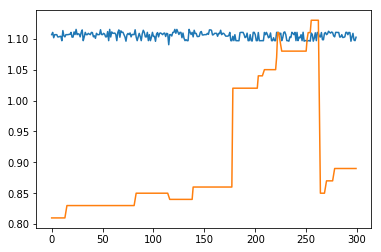

In [30]:
x, y = next(iter(train_dataset))
model = runner.model.eval()
r = model(x.cuda())
plt.plot(r[0][0].detach().cpu().numpy())
plt.plot(y[0][0].numpy())
plt.show()

In [31]:
import pandas as pd
import numpy as np

data_name = 'test.csv'
df = pd.read_csv(data_name)

x_data = np.stack((df['ta_red_cards_1'].values,
                   df['ta_red_cards_2'].values,
                   df['ta_ft_ht_hdp_sp'].values,
                   df['ta_ft_ht_hdp_x_n1'].values,
                   df['ta_ft_ht_hdp_x_0'].values,
                   df['ta_ft_ht_hdp_x_1'].values,
                   (df['ta_match_time']/5400.0).values
                  ), axis=1)

print(x_data.shape)
df.head()

(4043, 7)


,TA_HK,OP_HK,ta_is_favor,ta_hdp_goals,ta_GOAL1,ta_GOAL2,ta_red_cards_1,ta_red_cards_2,ta_ft_ht_hdp_sp,ta_ft_ht_hdp_x_n1,ta_ft_ht_hdp_x_0,ta_ft_ht_hdp_x_1,ta_match_time
0,0.99,1.149425,0,0,0,0,0,0,0.25,-12.449644,5.072688,10.145376,1
1,1.15,1.149425,0,0,0,0,0,0,0.25,-11.430316,4.606236,9.212473,1
2,1.15,1.149425,0,0,0,0,0,0,0.25,-9.391659,3.673333,7.346667,1
3,1.15,1.149425,0,0,0,0,0,0,0.25,-9.391659,3.673333,7.346667,1
4,1.15,1.149425,0,0,0,0,0,0,0.25,-1.237021,-0.058277,-0.116554,1


In [32]:
import numpy as np
import random

forecast_n1 = []
forecast_0 = []
forecast_1 = []

rc1 = []
rc2 = []

for i in range(len(df)):
    if i < 1:
        forecast_n1.append(0)
        forecast_0.append(0)
        forecast_1.append(0)
        
        rc1.append(0)
        rc2.append(0)
    else:
        forecast_n1.append(df['ta_ft_ht_hdp_x_n1'][i]-df['ta_ft_ht_hdp_x_n1'][i-1])
        forecast_0.append(df['ta_ft_ht_hdp_x_0'][i]-df['ta_ft_ht_hdp_x_0'][i-1])
        forecast_1.append(df['ta_ft_ht_hdp_x_1'][i]-df['ta_ft_ht_hdp_x_1'][i-1])

        rc1.append(df['ta_red_cards_1'][i]-df['ta_red_cards_1'][i-1])
        rc2.append(df['ta_red_cards_2'][i]-df['ta_red_cards_2'][i-1])
        
for i in range(len(df)): 

    x_data[i, -4] = forecast_n1[i]
    x_data[i, -3] = forecast_0[i]
    x_data[i, -2] = forecast_1[i]
    
    x_data[i, 0] = rc1[i]
    x_data[i, 1] = rc2[i]

    if pd.isnull(x_data).any():
        x_data[i] = x_data[i-1]

print(x_data.shape)

(4043, 7)


In [33]:
y_predict = []
model = runner.model.eval()

for i in range(1, len(x_data)):
    if i < 2:
        r = model(torch.from_numpy(np.array(x_data)[None, :i, :].transpose(0, 2, 1)).cuda().float())
        y_predict.append(r[0,0,-1].detach().cpu().numpy())
    else:
        if i < 600:
            first = np.array(x_data)[None, 0:i:2, :]
            second = np.array(x_data)[None, 1:i:2, :]
            first = first[:, :second.shape[1], :]
            inp = (first+second)/2
            inp = torch.from_numpy(inp.transpose(0, 2, 1)).cuda().float()
            r = model(inp)
            y_predict.append(r[0,0,-1].detach().cpu().numpy())
        else:
            inp = (np.array(x_data)[None, i-600:i:2,:]+ \
                                                    np.array(x_data)[None, i-600+1:i:2, :])/2.0
            inp = torch.from_numpy(inp.transpose(0, 2, 1)).cuda().float()
            r = model(inp)
            y_predict.append(r[0,0,-1].detach().cpu().numpy())


In [34]:
y_predict = np.array(y_predict)

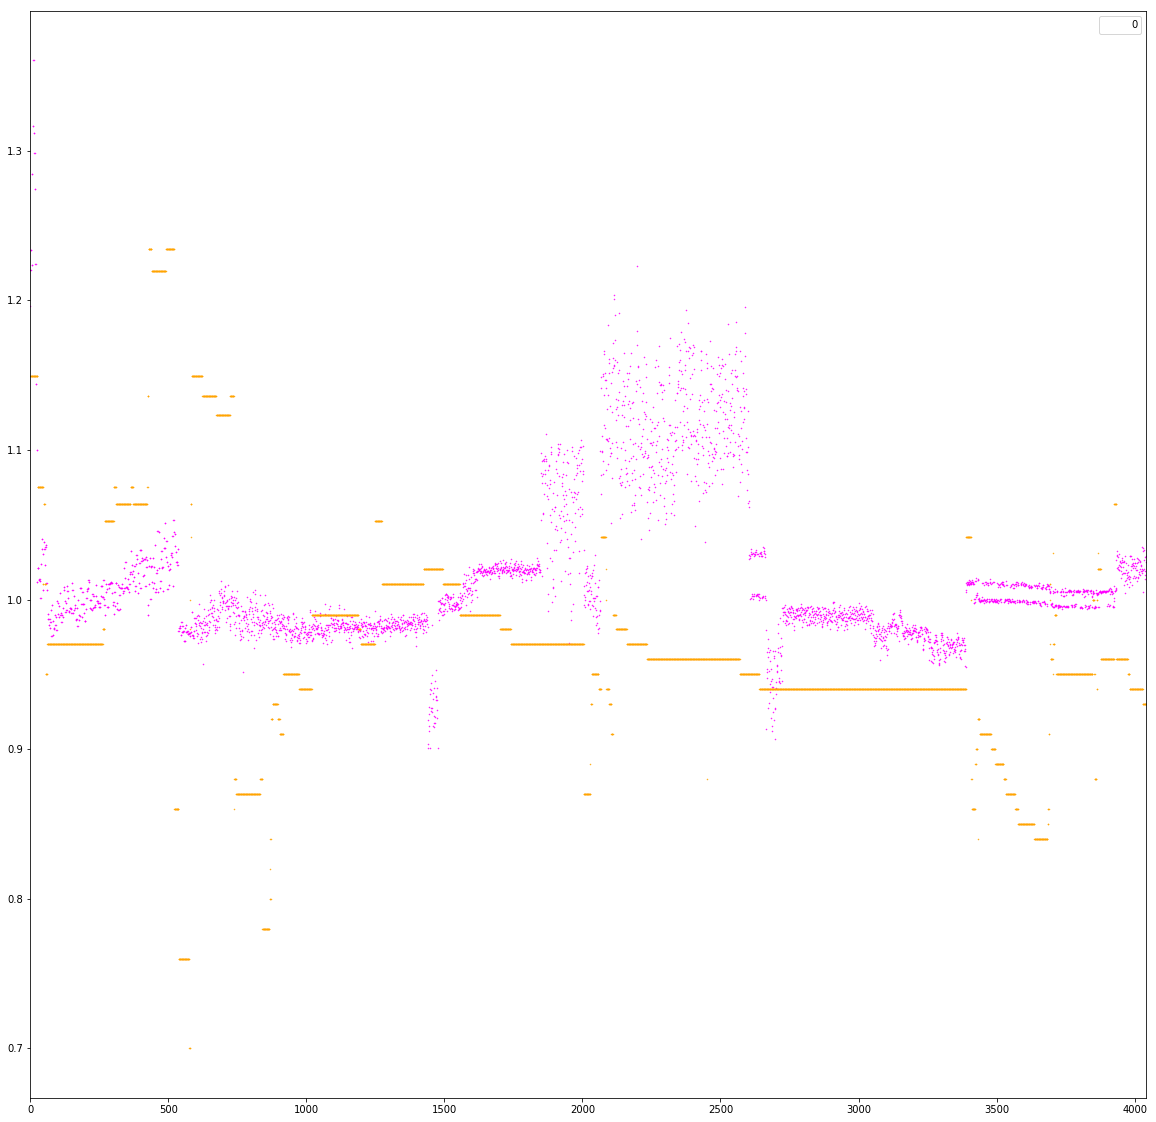

In [35]:
pd.DataFrame(y_predict).plot(style='.', markersize=1, color='magenta', figsize=(20, 20))
df['OP_HK'].plot(style='.', markersize=1, color='orange')